<h1>Modified pyamaze</h1>


In [1]:
"""
License
https://www.youtube.com/c/LearningOrbis
Copyright (c) 2021 Muhammad Ahsan Naeem
mahsan.naeem@gmail.com
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import random,datetime,csv,os
from tkinter import *
from enum import Enum
from collections import deque

class COLOR(Enum):
    '''
    This class is created to use the Tkinter colors easily.
    Each COLOR object has two color values.
    The first two objects (dark and light) are for theme and the two color
    values represent the Canvas color and the Maze Line color respectively.
    The rest of the colors are for Agents.
    The first value is the color of the Agent and the second is the color of
    its footprint
    '''
    dark=('gray11','white')
    light=('white','black')
    black=('black','dim gray')
    red=('red3','tomato')
    cyan=('cyan4','cyan4')
    green=('green4','pale green')
    blue=('DeepSkyBlue4','DeepSkyBlue2')
    yellow=('yellow2','yellow2')

class agent:
    '''
    The agents can be placed on the maze.
    They can represent the virtual object just to indcate the cell selected in Maze.
    Or they can be the physical agents (like robots)
    They can have two shapes (square or arrow)
    '''
    def __init__(self,parentMaze,x=None,y=None,shape='square',goal=None,filled=False,footprints=False,color:COLOR=COLOR.blue):
        '''
        parentmaze-->  The maze on which agent is placed.
        x,y-->  Position of the agent i.e. cell inside which agent will be placed
                Default value is the lower right corner of the Maze
        shape-->    square or arrow (as string)
        goal-->     Default value is the goal of the Maze
        filled-->   For square shape, filled=False is a smaller square
                    While filled =True is a biiger square filled in complete Cell
                    This option doesn't matter for arrow shape.
        footprints-->   When the aganet will move to some other cell, its footprints
                        on the previous cell can be placed by making this True
        color-->    Color of the agent.
        
        _orient-->  You don't need to pass this
                    It is used with arrow shape agent to shows it turning
        position--> You don't need to pass this
                    This is the cell (x,y)
        _head-->    You don't need to pass this
                    It is actually the agent.
        _body-->    You don't need to pass this
                    Tracks the body of the agent (the previous positions of it)
        '''
        self._parentMaze=parentMaze
        self.color=color
        if(isinstance(color,str)):
            if(color in COLOR.__members__):
                self.color=COLOR[color]
            else:
                raise ValueError(f'{color} is not a valid COLOR!')
        self.filled=filled
        self.shape=shape
        self._orient=0
        if x is None:x=parentMaze.rows
        if y is None:y=parentMaze.cols
        self.x=x
        self.y=y
        self.footprints=footprints
        self._parentMaze._agents.append(self)
        if goal==None:
            self.goal=self._parentMaze._goal
        else:
            self.goal=goal
        self._body=[]
        self.position=(self.x,self.y)
        
    @property
    def x(self):
        return self._x
    @x.setter
    def x(self,newX):
        self._x=newX
    @property
    def y(self):
        return self._y
    @y.setter
    def y(self,newY):
        self._y=newY
        w=self._parentMaze._cell_width
        x=self.x*w-w+self._parentMaze._LabWidth
        y=self.y*w-w+self._parentMaze._LabWidth
        if self.shape=='square':
            if self.filled:
                self._coord=(y, x,y + w, x + w)
            else:
                self._coord=(y + w/2.5, x + w/2.5,y + w/2.5 +w/4, x + w/2.5 +w/4)
        else:
            self._coord=(y + w/2, x + 3*w/9,y + w/2, x + 3*w/9+w/4)

        if(hasattr(self,'_head')):
            if self.footprints is False:
                self._parentMaze._canvas.delete(self._head)
            else:
                if self.shape=='square':
                    self._parentMaze._canvas.itemconfig(self._head, fill=self.color.value[1],outline="")
                    self._parentMaze._canvas.tag_raise(self._head)
                    try:
                        self._parentMaze._canvas.tag_lower(self._head,'ov')
                    except:
                        pass
                    if self.filled:
                        lll=self._parentMaze._canvas.coords(self._head)
                        oldcell=(round(((lll[1]-26)/self._parentMaze._cell_width)+1),round(((lll[0]-26)/self._parentMaze._cell_width)+1))
                        self._parentMaze._redrawCell(*oldcell,self._parentMaze.theme)
                else:
                    self._parentMaze._canvas.itemconfig(self._head, fill=self.color.value[1])#,outline='gray70')
                    self._parentMaze._canvas.tag_raise(self._head)
                    try:
                        self._parentMaze._canvas.tag_lower(self._head,'ov')
                    except:
                        pass
                self._body.append(self._head)
            if not self.filled or self.shape=='arrow':
                if self.shape=='square':
                    self._head=self._parentMaze._canvas.create_rectangle(*self._coord,fill=self.color.value[0],outline='') #stipple='gray75'
                    try:
                        self._parentMaze._canvas.tag_lower(self._head,'ov')
                    except:
                        pass
                else:
                    self._head=self._parentMaze._canvas.create_line(*self._coord,fill=self.color.value[0],arrow=FIRST,arrowshape=(3/10*w,4/10*w,4/10*w))#,outline=self.color.name)
                    try:
                        self._parentMaze._canvas.tag_lower(self._head,'ov')
                    except:
                        pass
                    o=self._orient%4
                    if o==1:
                        self._RCW()
                        self._orient-=1
                    elif o==3:
                        self._RCCW()
                        self._orient+=1
                    elif o==2:
                        self._RCCW()
                        self._RCCW()
                        self._orient+=2
            else:
                self._head=self._parentMaze._canvas.create_rectangle(*self._coord,fill=self.color.value[0],outline='')#stipple='gray75'
                try:
                    self._parentMaze._canvas.tag_lower(self._head,'ov')
                except:
                        pass
                self._parentMaze._redrawCell(self.x,self.y,theme=self._parentMaze.theme)
        else:
            self._head=self._parentMaze._canvas.create_rectangle(*self._coord,fill=self.color.value[0],outline='')#stipple='gray75'
            try:
                self._parentMaze._canvas.tag_lower(self._head,'ov')
            except:
                pass
            self._parentMaze._redrawCell(self.x,self.y,theme=self._parentMaze.theme)
    @property
    def position(self):
        return (self.x,self.y)
    @position.setter
    def position(self,newpos):
        self.x=newpos[0]
        self.y=newpos[1]
        self._position=newpos
    def _RCCW(self):
        '''
        To Rotate the agent in Counter Clock Wise direction
        '''
        def pointNew(p,newOrigin):
            return (p[0]-newOrigin[0],p[1]-newOrigin[1])
        w=self._parentMaze._cell_width
        x=self.x*w-w+self._parentMaze._LabWidth
        y=self.y*w-w+self._parentMaze._LabWidth
        cent=(y+w/2,x+w/2)
        p1=pointNew((self._coord[0],self._coord[1]),cent)
        p2=pointNew((self._coord[2],self._coord[3]),cent)
        p1CW=(p1[1],-p1[0])
        p2CW=(p2[1],-p2[0])
        p1=p1CW[0]+cent[0],p1CW[1]+cent[1]
        p2=p2CW[0]+cent[0],p2CW[1]+cent[1]
        self._coord=(*p1,*p2)  
        self._parentMaze._canvas.coords(self._head,*self._coord)
        self._orient=(self._orient-1)%4
 
        
    def _RCW(self):
        '''
        To Rotate the agent in Clock Wise direction
        '''
        def pointNew(p,newOrigin):
            return (p[0]-newOrigin[0],p[1]-newOrigin[1])
        w=self._parentMaze._cell_width
        x=self.x*w-w+self._parentMaze._LabWidth
        y=self.y*w-w+self._parentMaze._LabWidth
        cent=(y+w/2,x+w/2)
        p1=pointNew((self._coord[0],self._coord[1]),cent)
        p2=pointNew((self._coord[2],self._coord[3]),cent)
        p1CW=(-p1[1],p1[0])
        p2CW=(-p2[1],p2[0])
        p1=p1CW[0]+cent[0],p1CW[1]+cent[1]
        p2=p2CW[0]+cent[0],p2CW[1]+cent[1]
        self._coord=(*p1,*p2)  
        self._parentMaze._canvas.coords(self._head,*self._coord)
        self._orient=(self._orient+1)%4


    def moveRight(self,event):
        if self._parentMaze.maze_map[self.x,self.y]['E']==True:
            self.y=self.y+1
    def moveLeft(self,event):
        if self._parentMaze.maze_map[self.x,self.y]['W']==True:
            self.y=self.y-1
    def moveUp(self,event):
        if self._parentMaze.maze_map[self.x,self.y]['N']==True:
            self.x=self.x-1
            self.y=self.y
    def moveDown(self,event):
        if self._parentMaze.maze_map[self.x,self.y]['S']==True:
            self.x=self.x+1
            self.y=self.y
class textLabel:
    '''
    This class is to create Text Label to show different results on the window.
    '''
    def __init__(self,parentMaze,title,value):
        '''
        parentmaze-->   The maze on which Label will be displayed.
        title-->        The title of the value to be displayed
        value-->        The value to be displayed
        '''
        self.title=title
        self._value=value
        self._parentMaze=parentMaze
        # self._parentMaze._labels.append(self)
        self._var=None
        self.drawLabel()
    @property
    def value(self):
        return self._value
    @value.setter
    def value(self,v):
        self._value=v
        self._var.set(f'{self.title} : {v}')
    def drawLabel(self):
        self._var = StringVar()
        self.lab = Label(self._parentMaze._canvas, textvariable=self._var, bg="white", fg="black",font=('Helvetica bold',12),relief=RIDGE)
        self._var.set(f'{self.title} : {self.value}')
        self.lab.pack(expand = True,side=LEFT,anchor=NW)

class maze:
    '''
    This is the main class to create maze.
    '''
    def __init__(self,rows=10,cols=10):
        '''
        rows--> No. of rows of the maze
        cols--> No. of columns of the maze
        Need to pass just the two arguments. The rest will be assigned automatically
        maze_map--> Will be set to a Dicationary. Keys will be cells and
                    values will be another dictionary with keys=['E','W','N','S'] for
                    East West North South and values will be 0 or 1. 0 means that 
                    direction(EWNS) is blocked. 1 means that direction is open.
        grid--> A list of all cells
        path--> Shortest path from start(bottom right) to goal(by default top left)
                It will be a dictionary
        _win,_cell_width,_canvas -->    _win and )canvas are for Tkinter window and canvas
                                        _cell_width is cell width calculated automatically
        _agents-->  A list of aganets on the maze
        markedCells-->  Will be used to mark some particular cell during
                        path trace by the agent.
        _
        '''
        self.rows=rows
        self.cols=cols
        self.maze_map={}
        self.grid=[]
        self.path={} 
        self._cell_width=50  
        self._win=None 
        self._canvas=None
        self._agents=[]
        self._ourAgent=[]
        self.markCells=[]

    @property
    def grid(self):
        return self._grid
    @grid.setter        
    def grid(self,n):
        self._grid=[]
        y=0
        for n in range(self.cols):
            x = 1
            y = 1+y
            for m in range(self.rows):
                self.grid.append((x,y))
                self.maze_map[x,y]={'E':0,'W':0,'N':0,'S':0}
                x = x + 1 
    def _Open_East(self,x, y):
        '''
        To remove the East Wall of the cell
        '''
        self.maze_map[x,y]['E']=1
        if y+1<=self.cols:
            self.maze_map[x,y+1]['W']=1
    def _Open_West(self,x, y):
        self.maze_map[x,y]['W']=1
        if y-1>0:
            self.maze_map[x,y-1]['E']=1
    def _Open_North(self,x, y):
        self.maze_map[x,y]['N']=1
        if x-1>0:
            self.maze_map[x-1,y]['S']=1
    def _Open_South(self,x, y):
        self.maze_map[x,y]['S']=1
        if x+1<=self.rows:
            self.maze_map[x+1,y]['N']=1
    
    def CreateMaze(self,x=1,y=1,pattern=None,loopPercent=0,saveMaze=False,loadMaze=None,theme:COLOR=COLOR.dark):
        '''
        One very important function to create a Random Maze
        pattern-->  It can be 'v' for vertical or 'h' for horizontal
                    Just the visual look of the maze will be more vertical/horizontal
                    passages will be there.
        loopPercent-->  0 means there will be just one path from start to goal (perfect maze)
                        Higher value means there will be multiple paths (loops)
                        Higher the value (max 100) more will be the loops
        saveMaze--> To save the generated Maze as CSV file for future reference.
        loadMaze--> Provide the CSV file to generate a desried maze
        theme--> Dark or Light
        '''
        _stack=[]
        _closed=[]
        self.theme=theme
        self._goal=(x,y)
        if(isinstance(theme,str)):
            if(theme in COLOR.__members__):
                self.theme=COLOR[theme]
            else:
                raise ValueError(f'{theme} is not a valid theme COLOR!')
        def blockedNeighbours(cell):
            n=[]
            for d in self.maze_map[cell].keys():
                if self.maze_map[cell][d]==0:
                    if d=='E' and (cell[0],cell[1]+1) in self.grid:
                        n.append((cell[0],cell[1]+1))
                    elif d=='W' and (cell[0],cell[1]-1) in self.grid:
                        n.append((cell[0],cell[1]-1))
                    elif d=='N' and (cell[0]-1,cell[1]) in self.grid:
                        n.append((cell[0]-1,cell[1]))
                    elif d=='S' and (cell[0]+1,cell[1]) in self.grid:
                        n.append((cell[0]+1,cell[1]))
            return n
        def removeWallinBetween(cell1,cell2):
            '''
            To remove wall in between two cells
            '''
            if cell1[0]==cell2[0]:
                if cell1[1]==cell2[1]+1:
                    self.maze_map[cell1]['W']=1
                    self.maze_map[cell2]['E']=1
                else:
                    self.maze_map[cell1]['E']=1
                    self.maze_map[cell2]['W']=1
            else:
                if cell1[0]==cell2[0]+1:
                    self.maze_map[cell1]['N']=1
                    self.maze_map[cell2]['S']=1
                else:
                    self.maze_map[cell1]['S']=1
                    self.maze_map[cell2]['N']=1
        def isCyclic(cell1,cell2):
            '''
            To avoid too much blank(clear) path.
            '''
            ans=False
            if cell1[0]==cell2[0]:
                if cell1[1]>cell2[1]: cell1,cell2=cell2,cell1
                if self.maze_map[cell1]['S']==1 and self.maze_map[cell2]['S']==1:
                    if (cell1[0]+1,cell1[1]) in self.grid and self.maze_map[(cell1[0]+1,cell1[1])]['E']==1:
                        ans= True
                if self.maze_map[cell1]['N']==1 and self.maze_map[cell2]['N']==1:
                    if (cell1[0]-1,cell1[1]) in self.grid and self.maze_map[(cell1[0]-1,cell1[1])]['E']==1:
                        ans= True
            else:
                if cell1[0]>cell2[0]: cell1,cell2=cell2,cell1
                if self.maze_map[cell1]['E']==1 and self.maze_map[cell2]['E']==1:
                    if (cell1[0],cell1[1]+1) in self.grid and self.maze_map[(cell1[0],cell1[1]+1)]['S']==1:
                        ans= True
                if self.maze_map[cell1]['W']==1 and self.maze_map[cell2]['W']==1:
                    if (cell1[0],cell1[1]-1) in self.grid and self.maze_map[(cell1[0],cell1[1]-1)]['S']==1:
                        ans= True
            return ans
        def BFS(cell):
            '''
            Breadth First Search
            To generate the shortest path.
            This will be used only when there are multiple paths (loopPercent>0) or
            Maze is loaded from a CSV file.
            If a perfect maze is generated and without the load file, this method will
            not be used since the Maze generation will calculate the path.
            '''
            frontier = deque()
            frontier.append(cell)
            path = {}
            visited = {(self.rows,self.cols)}
            while len(frontier) > 0:
                cell = frontier.popleft()
                if self.maze_map[cell]['W'] and (cell[0],cell[1]-1) not in visited:
                    nextCell = (cell[0],cell[1]-1)
                    path[nextCell] = cell
                    frontier.append(nextCell)
                    visited.add(nextCell)
                if self.maze_map[cell]['S'] and (cell[0]+1,cell[1]) not in visited:    
                    nextCell = (cell[0]+1,cell[1])
                    path[nextCell] = cell
                    frontier.append(nextCell)
                    visited.add(nextCell)
                if self.maze_map[cell]['E'] and (cell[0],cell[1]+1) not in visited:
                    nextCell = (cell[0],cell[1]+1)
                    path[nextCell] = cell
                    frontier.append(nextCell)
                    visited.add(nextCell)
                if self.maze_map[cell]['N'] and (cell[0]-1,cell[1]) not in visited:
                    nextCell = (cell[0]-1,cell[1])
                    path[nextCell] = cell
                    frontier.append(nextCell)
                    visited.add(nextCell)
            fwdPath={}
            cell=self._goal
            while cell!=(self.rows,self.cols):
                try:
                    fwdPath[path[cell]]=cell
                    cell=path[cell]
                except:
                    print('Path to goal not found!')
                    return
            return fwdPath
        # if maze is to be generated randomly
        if not loadMaze:
            _stack.append((x,y))
            _closed.append((x,y))
            biasLength=2 # if pattern is 'v' or 'h'
            if(pattern is not None and pattern.lower()=='h'):
                biasLength=max(self.cols//10,2)
            if(pattern is not None and pattern.lower()=='v'):
                biasLength=max(self.rows//10,2)
            bias=0

            while len(_stack) > 0:
                cell = []
                bias+=1
                if(x , y +1) not in _closed and (x , y+1) in self.grid:
                    cell.append("E")
                if (x , y-1) not in _closed and (x , y-1) in self.grid:
                    cell.append("W")
                if (x+1, y ) not in _closed and (x+1 , y ) in self.grid:
                    cell.append("S")
                if (x-1, y ) not in _closed and (x-1 , y) in self.grid:
                    cell.append("N") 
                if len(cell) > 0:    
                    if pattern is not None and pattern.lower()=='h' and bias<=biasLength:
                        if('E' in cell or 'W' in cell):
                            if 'S' in cell:cell.remove('S')
                            if 'N' in cell:cell.remove('N')
                    elif pattern is not None and pattern.lower()=='v' and bias<=biasLength:
                        if('N' in cell or 'S' in cell):
                            if 'E' in cell:cell.remove('E')
                            if 'W' in cell:cell.remove('W')
                    else:
                        bias=0
                    current_cell = (random.choice(cell))
                    if current_cell == "E":
                        self._Open_East(x,y)
                        self.path[x, y+1] = x, y
                        y = y + 1
                        _closed.append((x, y))
                        _stack.append((x, y))

                    elif current_cell == "W":
                        self._Open_West(x, y)
                        self.path[x , y-1] = x, y
                        y = y - 1
                        _closed.append((x, y))
                        _stack.append((x, y))

                    elif current_cell == "N":
                        self._Open_North(x, y)
                        self.path[(x-1 , y)] = x, y
                        x = x - 1
                        _closed.append((x, y))
                        _stack.append((x, y))

                    elif current_cell == "S":
                        self._Open_South(x, y)
                        self.path[(x+1 , y)] = x, y
                        x = x + 1
                        _closed.append((x, y))
                        _stack.append((x, y))

                else:
                    x, y = _stack.pop()

            ## Multiple Path Loops
            if loopPercent!=0:
                
                x,y=self.rows,self.cols
                pathCells=[(x,y)]
                while x!=self.rows or y!=self.cols:
                    x,y=self.path[(x,y)]
                    pathCells.append((x,y))
                notPathCells=[i for i in self.grid if i not in pathCells]
                random.shuffle(pathCells)
                random.shuffle(notPathCells)
                pathLength=len(pathCells)
                notPathLength=len(notPathCells)
                count1,count2=pathLength/3*loopPercent/100,notPathLength/3*loopPercent/100
                
                #remove blocks from shortest path cells
                count=0
                i=0
                while count<count1: #these many blocks to remove
                    if len(blockedNeighbours(pathCells[i]))>0:
                        cell=random.choice(blockedNeighbours(pathCells[i]))
                        if not isCyclic(cell,pathCells[i]):
                            removeWallinBetween(cell,pathCells[i])
                            count+=1
                        i+=1
                            
                    else:
                        i+=1
                    if i==len(pathCells):
                        break
                #remove blocks from outside shortest path cells
                if len(notPathCells)>0:
                    count=0
                    i=0
                    while count<count2: #these many blocks to remove
                        if len(blockedNeighbours(notPathCells[i]))>0:
                            cell=random.choice(blockedNeighbours(notPathCells[i]))
                            if not isCyclic(cell,notPathCells[i]):
                                removeWallinBetween(cell,notPathCells[i])
                                count+=1
                            i+=1
                                
                        else:
                            i+=1
                        if i==len(notPathCells):
                            break
                self.path=BFS((self.rows,self.cols))
        else:
            # Load maze from CSV file
            with open(loadMaze,'r') as f:
                last=list(f.readlines())[-1]
                c=last.split(',')
                c[0]=int(c[0].lstrip('"('))
                c[1]=int(c[1].rstrip(')"'))
                self.rows=c[0]
                self.cols=c[1]
                self.grid=[]

            with open(loadMaze,'r') as f:
                r=csv.reader(f)
                next(r)
                for i in r:
                    c=i[0].split(',')
                    c[0]=int(c[0].lstrip('('))
                    c[1]=int(c[1].rstrip(')'))
                    self.maze_map[tuple(c)]={'E':int(i[1]),'W':int(i[2]),'N':int(i[3]),'S':int(i[4])}
            self.path=BFS((self.rows,self.cols))
        self._drawMaze(self.theme)
        agent(self,*self._goal,shape='square',filled=True,color=COLOR.green)
        if saveMaze:
            dt_string = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
            with open(f'maze--{dt_string}.csv','w',newline='') as f:
                writer=csv.writer(f)
                writer.writerow(['  cell  ','E','W','N','S'])
                for k,v in self.maze_map.items():
                    entry=[k]
                    for i in v.values():
                        entry.append(i)
                    writer.writerow(entry)
                f.seek(0, os.SEEK_END)
                f.seek(f.tell()-2, os.SEEK_SET)
                f.truncate()

    def _drawMaze(self,theme):
        '''
        Creation of Tkinter window and maze lines
        '''
        
        self._LabWidth=26 # Space from the top for Labels
        self._win=Tk()
        self._win.state('zoomed')
        self._win.title('PYTHON MAZE WORLD by Learning Orbis')
        
        scr_width=self._win.winfo_screenwidth()
        scr_height=self._win.winfo_screenheight()
        self._win.geometry(f"{scr_width}x{scr_height}+0+0")
        self._canvas = Canvas(width=scr_width, height=scr_height, bg=theme.value[0]) # 0,0 is top left corner
        self._canvas.pack(expand=YES, fill=BOTH)
        # Some calculations for calculating the width of the maze cell
        k=3.25
        if self.rows>=95 and self.cols>=95:
            k=0
        elif self.rows>=80 and self.cols>=80:
            k=1
        elif self.rows>=70 and self.cols>=70:
            k=1.5
        elif self.rows>=50 and self.cols>=50:
            k=2
        elif self.rows>=35 and self.cols>=35:
            k=2.5
        elif self.rows>=22 and self.cols>=22:
            k=3
        self._cell_width=round(min(((scr_height-self.rows-k*self._LabWidth)/(self.rows)),((scr_width-self.cols-k*self._LabWidth)/(self.cols)),90),3)
        
        # Creating Maze lines
        if self._win is not None:
            if self.grid is not None:
                for cell in self.grid:
                    x,y=cell
                    w=self._cell_width
                    x=x*w-w+self._LabWidth
                    y=y*w-w+self._LabWidth
                    if self.maze_map[cell]['E']==False:
                        l=self._canvas.create_line(y + w, x, y + w, x + w,width=2,fill=theme.value[1],tag='line')
                    if self.maze_map[cell]['W']==False:
                        l=self._canvas.create_line(y, x, y, x + w,width=2,fill=theme.value[1],tag='line')
                    if self.maze_map[cell]['N']==False:
                        l=self._canvas.create_line(y, x, y + w, x,width=2,fill=theme.value[1],tag='line')
                    if self.maze_map[cell]['S']==False:
                        l=self._canvas.create_line(y, x + w, y + w, x + w,width=2,fill=theme.value[1],tag='line')

    def _redrawCell(self,x,y,theme):
        '''
        To redraw a cell.
        With Full sized square agent, it can overlap with maze lines
        So the cell is redrawn so that cell lines are on top
        '''
        w=self._cell_width
        cell=(x,y)
        x=x*w-w+self._LabWidth
        y=y*w-w+self._LabWidth
        if self.maze_map[cell]['E']==False:
            self._canvas.create_line(y + w, x, y + w, x + w,width=2,fill=theme.value[1])
        if self.maze_map[cell]['W']==False:
            self._canvas.create_line(y, x, y, x + w,width=2,fill=theme.value[1])
        if self.maze_map[cell]['N']==False:
            self._canvas.create_line(y, x, y + w, x,width=2,fill=theme.value[1])
        if self.maze_map[cell]['S']==False:
            self._canvas.create_line(y, x + w, y + w, x + w,width=2,fill=theme.value[1])

    def enableArrowKey(self,a):
        '''
        To control an agent a with Arrow Keys
        '''
        self._win.bind('<Left>',a.moveLeft)
        self._win.bind('<Right>',a.moveRight)
        self._win.bind('<Up>',a.moveUp)
        self._win.bind('<Down>',a.moveDown)
    
    def enableWASD(self,a):
        '''
        To control an agent a with keys W,A,S,D
        '''
        self._win.bind('<a>',a.moveLeft)
        self._win.bind('<d>',a.moveRight)
        self._win.bind('<w>',a.moveUp)
        self._win.bind('<s>',a.moveDown)



    _tracePathList=[]
    def _tracePathSingle(self,a,p,goalPair,targetAgent,kill,showMarked,delay):
        '''
        An interal method to help tracePath method for tracing a path by agent.
        '''
        if  a == targetAgent and goalPair and (a.x,a.y) == goalPair[0][0]:
            agent(self,*a.goal,shape='square',filled=True,color=COLOR.yellow)
            for ag in self._ourAgent: #Reset goal for each agent
                ag.goal = goalPair[0][1]
            agent(self,*a.goal,shape='square',filled=True,color=COLOR.green)
            goalPair.pop(0)
    
        def killAgent(a):
            '''
            if the agent should be killed after it reaches the Goal or completes the path
            '''
            for i in range(len(a._body)):
                self._canvas.delete(a._body[i])
            self._canvas.delete(a._head) 
        w=self._cell_width
        if((a.x,a.y) in self.markCells and showMarked):
            w=self._cell_width
            x=a.x*w-w+self._LabWidth
            y=a.y*w-w+self._LabWidth
            self._canvas.create_oval(y + w/2.5+w/20, x + w/2.5+w/20,y + w/2.5 +w/4-w/20, x + w/2.5 +w/4-w/20,fill='red',outline='red',tag='ov')
            self._canvas.tag_raise('ov')
       
        if (a.x,a.y)==(a.goal):
            agent(self,*a.goal,shape='square',filled=True,color=COLOR.red)
            del maze._tracePathList[0][0][a]
            if maze._tracePathList[0][0]=={}:
                del maze._tracePathList[0]
                if len(maze._tracePathList)>0:
                    self.tracePath(maze._tracePathList[0][0],kill=maze._tracePathList[0][1],delay=maze._tracePathList[0][2])
            if kill:
                self._win.after(300, killAgent,a)         
            return
        # If path is provided as Dictionary
        if(type(p)==dict):
            if(len(p)==0):
                del maze._tracePathList[0][0][a]
                return
            if a.shape=='arrow':
                old=(a.x,a.y)
                new=p[(a.x,a.y)]
                o=a._orient
                
                if old!=new:
                    if old[0]==new[0]:
                        if old[1]>new[1]:
                            mov=3#'W' #3
                        else:
                            mov=1#'E' #1
                    else:
                        if old[0]>new[0]:
                            mov=0#'N' #0

                        else:
                            mov=2#'S' #2
                    if mov-o==2:
                        a._RCW()

                    if mov-o==-2:
                        a._RCW()
                    if mov-o==1:
                        a._RCW()
                    if mov-o==-1:
                        a._RCCW()
                    if mov-o==3:
                        a._RCCW()
                    if mov-o==-3:
                        a._RCW()
                    if mov==o:
                        a.x,a.y=p[(a.x,a.y)]
                else:
                    del p[(a.x,a.y)]
            else:    
                a.x,a.y=p[(a.x,a.y)]
        # If path is provided as String
        if (type(p)==str):
            if(len(p)==0):
                del maze._tracePathList[0][0][a]
                if maze._tracePathList[0][0]=={}:
                    del maze._tracePathList[0]
                    if len(maze._tracePathList)>0:
                        self.tracePath(maze._tracePathList[0][0],kill=maze._tracePathList[0][1],delay=maze._tracePathList[0][2])
                if kill:
                    
                    self._win.after(300, killAgent,a)         
                return
            if a.shape=='arrow':
                old=(a.x,a.y)
                new=p[0]
                o=a._orient
                if new=='N': mov=0
                elif new=='E': mov=1
                elif new=='S': mov=2
                elif new=='W': mov=3
                
                if mov-o==2:
                    a._RCW()

                if mov-o==-2:
                    a._RCW()
                if mov-o==1:
                    a._RCW()
                if mov-o==-1:
                    a._RCCW()
                if mov-o==3:
                    a._RCCW()
                if mov-o==-3:
                    a._RCW()
            if a.shape=='square' or mov==o:    
                move=p[0]
                if move=='E':
                    if a.y+1<=self.cols:
                        a.y+=1
                elif move=='W':
                    if a.y-1>0:
                        a.y-=1
                elif move=='N':
                    if a.x-1>0:
                        a.x-=1
                        a.y=a.y
                elif move=='S':
                    if a.x+1<=self.rows:
                        a.x+=1
                        a.y=a.y
                elif move=='C':
                    a._RCW()
                elif move=='A':
                    a._RCCW()
                p=p[1:]
        # If path is provided as List
        
        if (type(p)==list):
            
            if(len(p)==0):
                del maze._tracePathList[0][0][a]
                if maze._tracePathList[0][0]=={}:
                    del maze._tracePathList[0]
                    if len(maze._tracePathList)>0:
                        self.tracePath(maze._tracePathList[0][0],kill=maze._tracePathList[0][1],delay=maze._tracePathList[0][2])
                if kill:                    
                    self._win.after(300, killAgent,a)  
                return
            if a.shape=='arrow':
                old=(a.x,a.y)
                new=p[0]
                o=a._orient
                
                if old!=new:
                    if old[0]==new[0]:
                        if old[1]>new[1]:
                            mov=3#'W' #3
                        else:
                            mov=1#'E' #1
                    else:
                        if old[0]>new[0]:
                            mov=0#'N' #0

                        else:
                            mov=2#'S' #2
                    if mov-o==2:
                        a._RCW()

                    elif mov-o==-2:
                        a._RCW()
                    elif mov-o==1:
                        a._RCW()
                    elif mov-o==-1:
                        a._RCCW()
                    elif mov-o==3:
                        a._RCCW()
                    elif mov-o==-3:
                        a._RCW()
                    elif mov==o:
                        a.x,a.y=p[0]
                        del p[0]
                else:
                   
                    del p[0]
            else:    
                a.x,a.y=p[0]
                del p[0]

        self._win.after(delay, self._tracePathSingle,a,p,goalPair,targetAgent,kill,showMarked,delay)    

    def tracePath(self,d,goalPair,targetAgent,kill=False,delay=300,showMarked=False):
        '''
        A method to trace path by agent
        You can provide more than one agent/path details
        '''
        self._tracePathList.append((d,kill,delay))
        if maze._tracePathList[0][0]==d: 
            for a,p in d.items():
                self._ourAgent.append(a)
                if a.goal!=(a.x,a.y) and len(p)!=0:
                    self._tracePathSingle(a,p,goalPair,targetAgent,kill,showMarked,delay)
                    
                    
    def run(self):
        '''
        Finally to run the Tkinter Main Loop
        '''
        
        self._win.mainloop()


<h1>Generate 5 maze</h1>

In [2]:
# Save maze file

x,y =1,1
# m = maze(10,10)
# m.CreateMaze(x, y, loopPercent=125, saveMaze=True)
# m.run()


<h1>A star Algorithm</h1>

In [3]:
from queue import PriorityQueue

class AStar:
    def __init__(self, m, start, goal):
        self.m = m
        self.start = start
        self.goal = goal
        
    def h(self,cell1,cell2):
        x1,y1=cell1
        x2,y2=cell2
        return abs(x1-x2) + abs(y1-y2)
        
    def run(self):
        m = self.m
        start = self.start
        goal = self.goal
        
        g_score={cell:float('inf') for cell in m.grid}
        g_score[start]=0
        f_score={cell:float('inf') for cell in m.grid}
        f_score[start]=self.h(start,(1,1))

        open=PriorityQueue()
        open.put((self.h(start,(1,1)),self.h(start,(1,1)),start))
        aPath={}
        searchPath=[]

        while not open.empty():
            currCell=open.get()[2]
            searchPath.append(currCell)

            if currCell==goal:
                break

            for d in "ESNW":
                if m.maze_map[currCell][d]==True:
                    if d=="N":
                        childCell=(currCell[0]-1, currCell[1])
                    elif d=="S":
                        childCell=(currCell[0]+1, currCell[1])
                    elif d=="W":
                        childCell=(currCell[0], currCell[1]-1)
                    elif d=="E":
                        childCell=(currCell[0], currCell[1]+1)

                    temp_g_score = g_score[currCell] + 1
                    temp_f_score = temp_g_score + self.h(childCell, (1,1))

                    if temp_f_score < f_score[childCell]:
                        g_score[childCell] = temp_g_score
                        f_score[childCell] = temp_f_score
                        open.put((temp_f_score, self.h(childCell, (1,1)), childCell))
                        aPath[childCell] = currCell

        fwdPath=[]
        cell=goal

        while cell!=start:
            fwdPath.append(aPath[cell])
            cell=aPath[cell]

        fwdPath.reverse()
        fwdPath.append(goal)
        return fwdPath

<h1>IDDFS</h1>

In [4]:
class IDDFS:
    def __init__(self, m, start, goal):
        self.m = m
        self.start = start
        self.goal = goal
        self.path = dict()
        self.explored = {self.start:0}
        self.maxDepth = 1

    def run(self):
        while True:
            found = self.DLS(self.start, 0)
            if found:
                return self.pathToList()
            else:
                self.maxDepth += 1
                self.path = dict()
                self.explored = {self.start:0}

    def DLS(self, p, curDepth):
        if curDepth > self.maxDepth:
            return False

        if p == self.goal:
            return True

        children = []
        for d in "ESNW":
            if m.maze_map[p][d]:
                if d == "E":
                    cell = (p[0], p[1]+1)
                elif d == "W":
                    cell = (p[0], p[1]-1)
                elif d == "S":
                    cell = (p[0]+1, p[1])
                else:
                    cell = (p[0]-1, p[1])

                if cell in self.explored and curDepth >= self.explored[cell]:
                    continue
                    
                children.append(cell)
                self.path[cell] = p
                self.explored[cell] = curDepth 

        for child in children:
            found = self.DLS(child, curDepth + 1)
            if found:
                return True
        return False

    def pathToList(self):
        cell = self.goal
        res = [self.goal]
        while cell != self.start:
            cell = self.path[cell]
            res.append(cell)
        return res[::-1]

<h1>Goal Randomizer Function</h1>

In [5]:
import random
def goalRandomizer(currentStart1, currentStart2, prevGoals):
    minNo = 1
    maxNo = 10
    exceptList = [currentStart1, currentStart2, *prevGoals]
    newGoal = None
    while True:
        newGoal = (random.randint(minNo, maxNo), random.randint(minNo, maxNo))
        if newGoal not in exceptList:
            return newGoal

<h1>Driver Code</h1>

In [6]:
from time import perf_counter as time

def dynamicSearch(m, start, goal):
                                
    #pathList = []     # Record each original path
    goalList = [goal] # Record 3 goals
    goalPair = [] #record short circuit
    temp = time()   
    pathA = [AStar(m, start, goal).run()]
    timerA = time() - temp
    temp = time()   
    pathI = [IDDFS(m, start, goal).run()]
    timerI = time() - temp  
    totalPathA = []
    totalPathI = []


    #starts = [start] 
    for i in range(2): #running algorithm prediction
        idx = min(len(pathA[i]), len(pathI[i])) // 2 #find shortest path divide 2
        newStartA = pathA[i][idx]
        totalPathA += pathA[i][:idx]
        newStartI = pathI[i][idx]
        totalPathI += pathI[i][:idx]

        newGoal = goalRandomizer(newStartA, newStartI, goalList)
        goalList.append(newGoal)
        goalPair.append(( (newStartA),(newGoal) ))
        
        temp = time()   
        newPathA = AStar(m, newStartA, newGoal).run()
        timerA += (time() - temp)
        pathA.append(newPathA)
        temp = time()  
        newPathI = IDDFS(m, newStartI, newGoal).run()
        timerI += (time() - temp)
        pathI.append(newPathI)
   
    totalPathA += pathA[-1]
    totalPathI += pathI[-1]


    #Debug output
    #print("StartCell 1:", starts[0] )
    #print("path1:", path[0] )
    #print("secondStartCell:", starts[1] )
    #print("path2:", path[1])
    #print("thirdStartCell:", starts[2] )
    #print("path3:", path[2])
    #print("totalPath: ", totalPath)
    #print("goalPair", goalPair)
    return totalPathA, totalPathI, goalPair, timerA, timerI

<h1>Main Code</h1>

Text(0, 0.5, 'Algorithm Search Time')

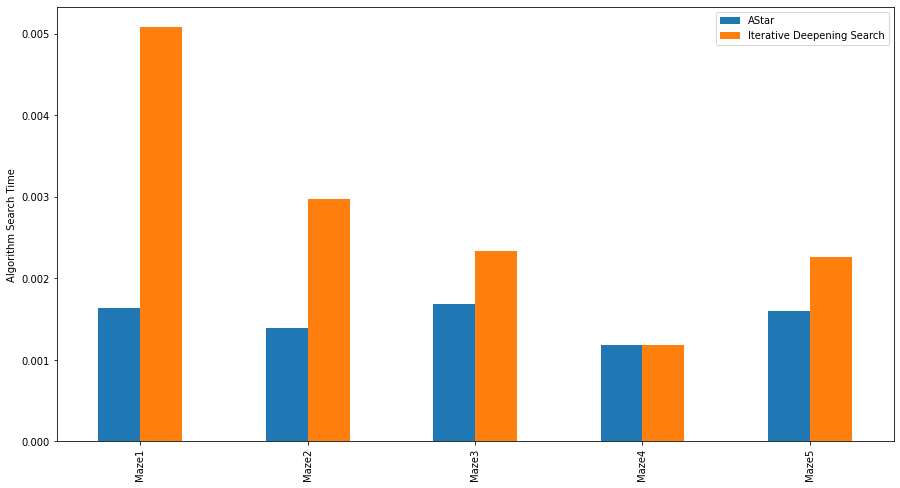

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

goals =[(10,10), (9, 9), (10,9), (8,8), (8,9)]
starts =[(1,1), (1,2), (2,1), (2,2), (1,3)]

totalMaze = len(goals)
searchTimeArr = []
for index in range(totalMaze):
    goal = goals[index]
    start = starts[index]
    m = maze()
    m.CreateMaze(goal[0], goal[1], loadMaze ='maze' + str(index + 1) + '.csv')
    totalPathA, totalPathI, goalPair, timerA, timerI=dynamicSearch(m, start, goal)
#     print("i:", index)
#     print("timerA:", timerA)
#     print("timerI:", timerI)
    searchTimeArr.append([timerA,timerI])
    a=agent(m,start[0], start[1], footprints=True, color='dark')
    b=agent(m,start[0], start[1], footprints=True, color="blue") 
    m.tracePath({a:totalPathA, b:totalPathI},goalPair,a,delay=50)
    m.run()

df = pd.DataFrame(searchTimeArr,index=["Maze" + str(i+1) for i in range(totalMaze)],
                   columns=['AStar', 'Iterative Deepening Search'])

df.plot(kind="bar",figsize=(15, 8))
plt.ylabel("Algorithm Search Time")




In [8]:
df

,AStar,Iterative Deepening Search
Maze1,0.001632,0.005080
Maze2,0.001388,0.002975
Maze3,0.001680,0.002333
Maze4,0.001185,0.001178
Maze5,0.001602,0.002258
